# GARCH-Based VaR Estimation for FX

In [138]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
from scipy.stats import norm, chi2

In this small project, we use GARCH-based VaR estimation for the daily returns of the EURCHF. Relying on GARCH allows us to capture the volatility clustering exhibited by FX markets and capture the volatility spikes caused by central bank interventions.

In [139]:
# Fetch historical EURCHF exchange rate
df_eurchf = yf.download("EURCHF=X", start='2015-01-01', end='2025-01-01', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [140]:
df_eurchf

Price,Close,High,Low,Open,Volume
Ticker,EURCHF=X,EURCHF=X,EURCHF=X,EURCHF=X,EURCHF=X
Date,,,,,
2015-01-01,1.20279,1.20279,1.20279,1.20279,0
2015-01-02,1.20210,1.20270,1.20090,1.20219,0
2015-01-05,1.20150,1.20209,1.20080,1.20150,0
2015-01-06,1.20133,1.20190,1.20080,1.20130,0
2015-01-07,1.20090,1.20118,1.19980,1.20080,0
...,...,...,...,...,...
2024-12-25,0.93870,0.93710,0.93640,0.93650,0
2024-12-26,0.93525,0.93804,0.93508,0.93525,0


In [141]:
# Eliminate MultiIndex
df_eurchf.columns = df_eurchf.columns.get_level_values(0)
df_eurchf.columns.name = None

In [142]:
df_eurchf

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-01,1.20279,1.20279,1.20279,1.20279,0
2015-01-02,1.20210,1.20270,1.20090,1.20219,0
2015-01-05,1.20150,1.20209,1.20080,1.20150,0
2015-01-06,1.20133,1.20190,1.20080,1.20130,0
2015-01-07,1.20090,1.20118,1.19980,1.20080,0
...,...,...,...,...,...
2024-12-25,0.93870,0.93710,0.93640,0.93650,0
2024-12-26,0.93525,0.93804,0.93508,0.93525,0
2024-12-27,0.93683,0.94050,0.93599,0.93683,0


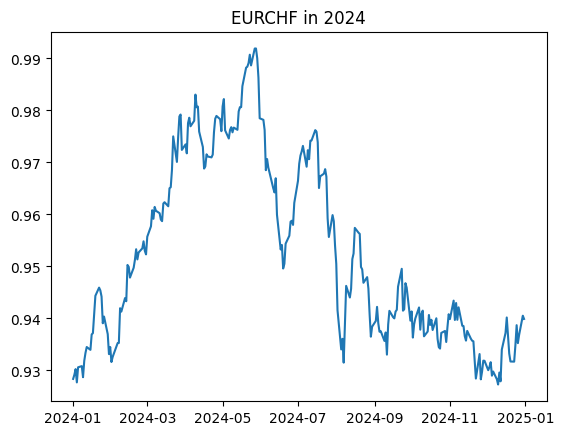

In [143]:
# Let's have a quick look at the last year
df_eurchf_ly = df_eurchf[df_eurchf.index.year == 2024]
plt.plot(df_eurchf_ly.index, df_eurchf_ly["Close"])
plt.title("EURCHF in 2024");

In [144]:
# Compute returns and rescale for more efficient modelling
returns = 1000 * np.log(df_eurchf["Close"] / df_eurchf["Close"].shift(1)).dropna()

In [145]:
returns

Date
2015-01-02   -0.573817
2015-01-05   -0.499235
2015-01-06   -0.141593
2015-01-07   -0.357991
2015-01-08    0.000000
                ...   
2024-12-25    4.099185
2024-12-26   -3.682105
2024-12-27    1.687962
2024-12-30    3.931083
2024-12-31   -0.659435
Name: Close, Length: 2606, dtype: float64

Using the past 500 days to compute the GARCH(1,1) parameters and a confidence level of $1-\alpha=0.99$, we compute the VaR and backtest it against actual losses. The GARCH(1,1) is defined as
$$\sigma_t^2= \alpha_0+\alpha_1\epsilon_{t-1}^2+\beta_1\sigma_{t-1}^2$$
Compared to ARCH, GARCH also incorporates the past variances $\sigma_{t-1}^2$, allowing the model to capture long-term persistance in volatility clustering more efficiently with fewer parameters.

In [146]:
# Rolling window
window_size = 500
confid_lvl = .99
z_score = norm.ppf(1 - confid_lvl)

# Define containers to store the results
var_estimates = []
realized_losses = []

# Iterate over 500 day window
for i in range(window_size, len(returns)):
    train_data = returns[i - window_size : i]
    garch_model = arch_model(train_data, vol="Garch", p=1, q=1)
    garch_fit = garch_model.fit(disp="off")
    
    # Predict 1-day ahead volatility
    pred = garch_fit.forecast(horizon=1)
    vol_pred = np.sqrt(pred.variance.iloc[-1, 0])
    
    # Compute 1-day ahead VaR
    var_99 = z_score * vol_pred
    var_estimates.append(var_99)
    
    # Store actual return for backtesting
    realized_losses.append(returns.iloc[i])

In [147]:
# Convert to DataFrame
df_var = pd.DataFrame({
    "VaR_99": var_estimates,
    "Realized_Loss": realized_losses,
    }, index=returns.index[window_size:])

In [148]:
df_var

,VaR_99,Realized_Loss
Date,,
2016-12-02,-7.583636,0.427032
2016-12-05,-7.622681,-4.296881
2016-12-06,-7.675825,9.480615
2016-12-07,-7.785108,-0.526350
2016-12-08,-7.813175,0.683288
...,...,...
2024-12-25,-7.222960,4.099185
2024-12-26,-7.348144,-3.682105
2024-12-27,-7.384613,1.687962


## Backtesting

Counting VaR Breaches, i.e., how many times realized loss < VaR

In [149]:
df_var["Breach"] = df_var["Realized_Loss"] < df_var["VaR_99"]
n_breaches = df_var["Breach"].sum()
n_obs = len(df_var)

**Kupiec Likelihood Ratio Test**: Evaluate if observed breaches match the expected breaches under the assumed confidence level. The null hypothesis assumes that the observed violation rate $\frac{S_n}{n}$ is statistically equal to the expected violation rate $p=1-\alpha$.

$$LR_{uc}=-2\ln\left(\frac{(1-p)^{n-S_n}p^{S_n}}{(1-\frac{S_n}{n})^{n-S_n}(\frac{S_n}{n})^{S_n}}\right)\sim\chi_1^2$$

In [150]:
p_fail = 1 - confid_lvl
obs_fail_rate = n_breaches / n_obs
LR_uc = -2 * (np.log((1 - p_fail) ** (n_obs - n_breaches) * p_fail ** n_breaches) -
              np.log((1 - obs_fail_rate) ** (n_obs - n_breaches) * obs_fail_rate ** n_breaches))

In [151]:
p_val = 1 - chi2.cdf(LR_uc, df=1)

In [152]:
print(f"Percentage of VaR Breaches: {n_breaches / n_obs:.2%}")
print(f"Kupiec Test Statistic: {LR_uc:.3f}")
print(f"p-Value: {p_val:.3f}")

Percentage of VaR Breaches: 1.80%
Kupiec Test Statistic: 11.114
p-Value: 0.001


As the p-value is less than $\alpha$, we have to reject $H_0$. Hence, the observed violation rate is *not* statistically equal to the expected violation rate. This suggests that our model is not well calibrated. Since we would expect fewer VaR breaches, let's try to increase the window size and repeat the test.

In [153]:
# Rolling window
window_size = 1000
confid_lvl = .99
z_score = norm.ppf(1 - confid_lvl)

# Define containers to store the results
var_estimates = []
realized_losses = []

# Iterate over 500 day window
for i in range(window_size, len(returns)):
    train_data = returns[i - window_size : i]
    garch_model = arch_model(train_data, vol="Garch", p=1, q=1)
    garch_fit = garch_model.fit(disp="off")
    
    # Predict 1-day ahead volatility
    pred = garch_fit.forecast(horizon=1)
    vol_pred = np.sqrt(pred.variance.iloc[-1, 0])
    
    # Compute 1-day ahead VaR
    var_99 = z_score * vol_pred
    var_estimates.append(var_99)
    
    # Store actual return for backtesting
    realized_losses.append(returns.iloc[i])

In [154]:
# Convert to DataFrame
df_var = pd.DataFrame({
    "VaR_99": var_estimates,
    "Realized_Loss": realized_losses,
    }, index=returns.index[window_size:])

In [155]:
df_var

,VaR_99,Realized_Loss
Date,,
2018-11-06,-7.029856,3.216047
2018-11-07,-6.955023,-0.453808
2018-11-08,-6.817757,-0.069931
2018-11-09,-6.673123,-1.843589
2018-11-12,-6.585528,-3.794207
...,...,...
2024-12-25,-7.165869,4.099185
2024-12-26,-7.314662,-3.682105
2024-12-27,-7.358897,1.687962


In [156]:
df_var["Breach"] = df_var["Realized_Loss"] < df_var["VaR_99"]
n_breaches = df_var["Breach"].sum()
n_obs = len(df_var)

In [157]:
p_fail = 1 - confid_lvl
obs_fail_rate = n_breaches / n_obs
LR_uc = -2 * (np.log((1 - p_fail) ** (n_obs - n_breaches) * p_fail ** n_breaches) -
              np.log((1 - obs_fail_rate) ** (n_obs - n_breaches) * obs_fail_rate ** n_breaches))

In [158]:
p_val = 1 - chi2.cdf(LR_uc, df=1)

In [159]:
print(f"Percentage of VaR Breaches: {n_breaches / n_obs:.2%}")
print(f"Kupiec Test Statistic: {LR_uc:.3f}")
print(f"p-Value: {p_val:.3f}")

Percentage of VaR Breaches: 1.37%
Kupiec Test Statistic: 1.989
p-Value: 0.158


There we go! Now we cannot reject the Null and the expected violation rate is statistically equal to the observed violation rate. This indicates that our model is well calibrated.